In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#parse_dates: dates will automatically be read in the proper format
data=pd.read_excel('walmart_sales.xlsx',index_col=[0],parse_dates=True) 

In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head(5)

,Sales
Date,
2010-02-01,131963.11
2010-03-01,91237.14
2010-04-01,150516.76
2010-05-01,66694.15
2010-06-01,66740.70


In [7]:
data.describe()

,Sales
count,33.000000
mean,96727.709091
std,34460.938312
min,59061.950000
25%,69146.590000
50%,83045.570000
75%,125600.120000
max,174512.070000


<AxesSubplot:xlabel='Date'>

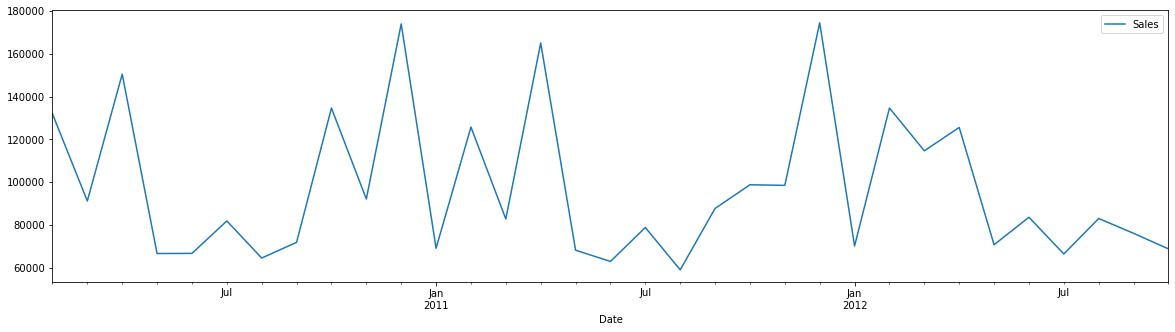

In [8]:
data.plot(figsize=(20,5))

<AxesSubplot:xlabel='Date'>

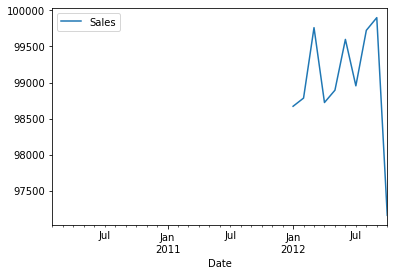

In [9]:
#since trend is not clear
#smoothing of time series (remove initial values)
data_ma=data.rolling(window=24).mean()
data_ma.plot()

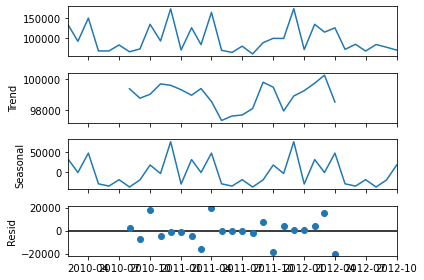

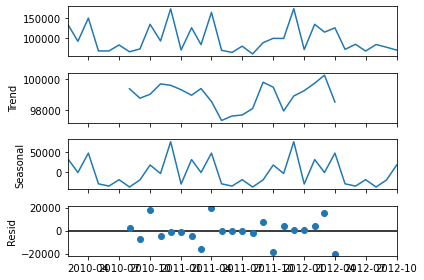

In [10]:
# seasonality: periodic pattern considered for a fixed short duration
# trend: decreasing,increasing or constant over a long period with unknown end
# level: demand varies over time, but is around an avg value 
# resid: random fluctuations(variations) after removal of above 2

explained_data=seasonal_decompose(data,model="addictive",period=12)
explained_data.plot()

In [11]:
#test for stationarity 
#Augmented Dickey-Fuller 

from statsmodels.tsa.stattools import adfuller

result=adfuller(data.dropna())
print("p value:",result[1])

# p<0.05 stationary and p>0.05 non stationary

p value: 1.6957303755384714e-16


# Holt Winter's Method

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

    # Univariate time series - only one quantity is recorded over a period of time in regular increments 
    # exponential smoothing 
            # - curr value depends on(or is sum of) past values (lags) 
            # - each prev value away from curr value is given decreasing weights 
            # - smoothing is done to reduce noise and highlight t,s for easy, accurate pattern identification
    # Holt winter's method - uses exponential smoothing to forecast - components - level(l), trend(t), seasonality(s)

    # parameters of HWES method - alpha, beta, gamma - determine weights to be assigned
    # alpha- level smoothing factor, beta- trend smoothing factor, gamma- seasonality smoothing factor
    # avg of weights taken to smooth each time

<AxesSubplot:title={'center':'Holt Winters Single Exponential Smoothing'}, xlabel='Date'>

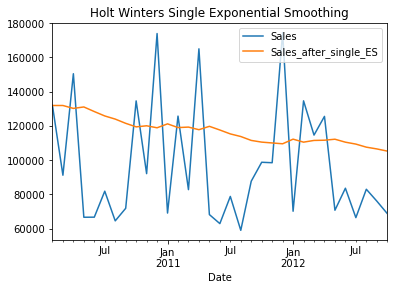

In [13]:
# Single exponential smoothing - forecasting with no trend, no seasonality
time_period=12
alpha=1/(2*time_period)
data['Sales_after_single_ES'] = SimpleExpSmoothing(data['Sales']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues      
data[['Sales','Sales_after_single_ES']].plot(title='Holt Winters Single Exponential Smoothing')

<AxesSubplot:title={'center':'Holt Winters: Additive and Multiplicative Trend'}, xlabel='Date'>

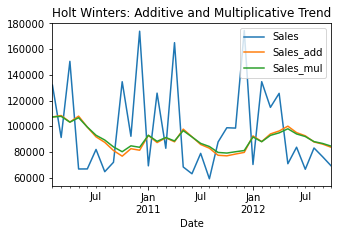

In [14]:
# since data has trend
# Double exponential smoothing (Additive and Multiplicative trend pattern)
data['Sales_add'] = ExponentialSmoothing(data['Sales'],trend='add').fit().fittedvalues
data['Sales_mul'] = ExponentialSmoothing(data['Sales'],trend='mul').fit().fittedvalues
data[['Sales','Sales_add','Sales_mul']].plot(title='Holt Winters: Additive and Multiplicative Trend',figsize=(5,3))

<AxesSubplot:title={'center':'Holt Winters: Additive and Multiplicative Seasonality'}, xlabel='Date'>

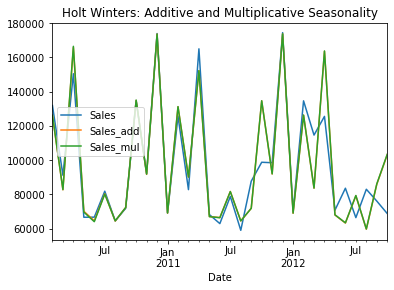

In [15]:
# since data has seasonality
# Triple exponential smoothing (Additive and Multiplicative seasonality pattern)
data['Sales_add'] = ExponentialSmoothing(data['Sales'],seasonal='add',seasonal_periods=12).fit().fittedvalues
data['Sales_mul'] = ExponentialSmoothing(data['Sales'],seasonal='mul',seasonal_periods=12).fit().fittedvalues
data[['Sales','Sales_add','Sales_mul']].plot(title='Holt Winters: Additive and Multiplicative Seasonality')

#data has additive seasonality

In [16]:
#split train and test data
train_data=data[:24]
test_data=data[20:34]

In [17]:
#model building
start=time.time()
result_model = ExponentialSmoothing(train_data['Sales'],trend='add',seasonal='add',seasonal_periods=12).fit()
end=time.time()
print("Model Fitting Time:",end-start)

Model Fitting Time: 0.2175436019897461


Text(0.5, 1.0, 'Holt Winters Exponential Smoothing')

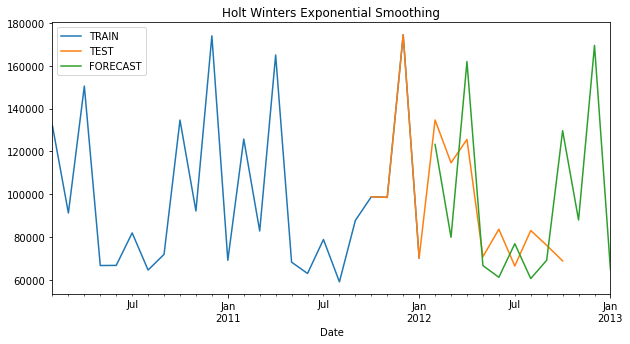

In [18]:
test_predictions = result_model.forecast(12)
train_data['Sales'].plot(legend=True,label='TRAIN')
test_data['Sales'].plot(legend=True,label='TEST',figsize=(10,5))
test_predictions.plot(legend=True,label='FORECAST')

plt.legend(loc="best")
plt.title('Holt Winters Exponential Smoothing')

In [19]:
final=result_model.predict(start=29, end=34)
print(final)

2012-07-01     76868.390419
2012-08-01     60599.111822
2012-09-01     69143.650421
2012-10-01    129681.932761
2012-11-01     87965.037649
2012-12-01    169547.403044
Freq: MS, dtype: float64


In [20]:
y_pred=result_model.forecast(10)[0]
y_true=data[25:]
y_train=data[:25]
x=y_true-y_pred

#easier to compare models as the values are in percentage
print('mean absolute percentage error',"\n")
print(np.mean(np.abs(x)/np.abs(y_true)),"\n") # mean absolute percentage error
      
print('mean absolute scaled error',"\n")
#mase - mean absolute scaled error - irrespective of scale and time, evaluates timeseries data
scale=mean_absolute_error(y_train[1:],y_train[:-1])
print(np.mean(np.abs(x/scale)))

mean absolute percentage error 

Sales                    0.507134
Sales_after_single_ES    0.127588
Sales_add                0.591087
Sales_mul                0.588369
dtype: float64 

mean absolute scaled error 

Sales                    1.016608
Sales_after_single_ES    0.374651
Sales_add                1.213970
Sales_mul                1.210964
dtype: float64
